# We build the protein and sample dataframes and omit any poor quality samples


## First though Impute data

We used the DreamAI package to impute missing values from the protein data.


```

#install_github("WangLab-MSSM/DreamAI/Code")
#https://github.com/WangLab-MSSM/DreamAI
library("DreamAI")

prot_data <- read.csv('../data/raw_downloads/CPTAC/6_CPTAC3_CCRCC_Whole_abundance_gene_protNorm=2_CB.tsv', sep='\t')
colnames(prot_data)
prot_num_data <- prot_data[, 5:length(colnames(prot_data))]
rownames(prot_num_data) <- prot_data$Index
imputed_data <- DreamAI(prot_num_data, k = 10, maxiter_MF = 10, ntree = 100,
        maxnodes = NULL, maxiter_ADMIN = 30, tol = 10^(-2),
        gamma_ADMIN = NA, gamma = 50, CV = FALSE,
        fillmethod = "row_mean", maxiter_RegImpute = 10,
        conv_nrmse = 1e-06, iter_SpectroFM = 40, method = c("KNN",
                                                            "MissForest", "ADMIN", "Birnn", "SpectroFM", "RegImpute"),
        out = c("Ensemble"))

ens_data <- imputed_data$Ensemble
write.csv(ens_data, '../data/sircle/F1_DE_input_TvN/6_CPTAC3_CCRCC_Whole_abundance_gene_protNorm=2_CB_DreamAI-imputed.csv')
```

### Next we want to filter poor quality samples

Using the imputed data, have a look at the quality of the samples from the protein data.


In [11]:
import math
import pandas as pd
import numpy as np

base_dir = '../data/'
data_dir = f'{base_dir}raw_downloads/CPTAC/'
output_dir = f'{base_dir}sircle/F1_DE_input_TvN/'
fig_dir = '../figures/'
supp_dir = f'{base_dir}raw_downloads/supps/'
gene_name = 'hgnc_symbol'
save_fig = False
# Proteomics 
# Need to make a sample sheet (i.e. with the clinical information associated with the cases)
# Let's just make it up for now
prot_og_df = pd.read_csv(f'{data_dir}6_CPTAC3_CCRCC_Whole_abundance_gene_protNorm=2_CB.tsv', sep='\t')
prot_df = pd.read_csv(f'{output_dir}6_CPTAC3_CCRCC_Whole_abundance_gene_protNorm=2_CB_DreamAI-imputed.csv', index_col=0)
prot_df['external_gene_name'] = prot_df.index
clin_df = pd.read_csv(f'{data_dir}Patient_Clinical_Attributes.csv')
clin_prot_df = pd.read_csv(f'{data_dir}S044_CPTAC_CCRCC_Discovery_Cohort_Specimens_r1_Sept2018.csv')
# First things we want to merge this with our gene names etc
annotation_file = f'{supp_dir}hsapiens_gene_ensembl-GRCh38.p13_external_synonym.csv'
annot = pd.read_csv(annotation_file)
prot_df = prot_df.join(annot.set_index('external_gene_name'), how="left", rsuffix='_')
# Drop duplicates (we don't have any dups based on geen ID going into this so we know)
# that this was just introduced with the name mapping
meta_cols = [c for c in prot_df.columns if 'CPT' not in c and 'QC' not in c and 'NC' not in c]
# non-ccrcc cases as stated in Sup Table 1 from the study
non_ccrcc = ['C3L-00359', 'C3N-00313', 'C3N-00435', 'C3N-00492', 'C3N-00832', 'C3N-01175', 'C3N-01180']

cols = [c for c in prot_df.columns if 'CPT' in c]
prot_df = prot_df[meta_cols + cols]
prot_df

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,external_gene_name,ensembl_gene_id,chromosome_name,start_position,end_position,strand,entrezgene_id,external_synonym,hgnc_symbol,CPT0079430001,...,CPT0012080003,CPT0021240003,CPT0009020003,CPT0017450001,CPT0009060003,CPT0012900004,CPT0017410003,CPT0009080003,CPT0012920003,CPT0009000003
A1BG,A1BG,ENSG00000121410,19,58345178.0,58353492.0,-1.0,1.0,NaN,A1BG,24.762998,...,25.407447,25.084466,25.794049,24.582934,24.875762,25.398878,25.23929,24.812949,25.320314,25.234656
A1CF,A1CF,ENSG00000148584,10,50799409.0,50885675.0,-1.0,29974.0,ACF,A1CF,21.803441,...,21.414654,20.563227,21.363325,21.573985,21.652046,22.094532,21.14661,21.843023,21.404158,21.215747
A1CF,A1CF,ENSG00000148584,10,50799409.0,50885675.0,-1.0,29974.0,ACF64,A1CF,21.803441,...,21.414654,20.563227,21.363325,21.573985,21.652046,22.094532,21.14661,21.843023,21.404158,21.215747
A1CF,A1CF,ENSG00000148584,10,50799409.0,50885675.0,-1.0,29974.0,ACF65,A1CF,21.803441,...,21.414654,20.563227,21.363325,21.573985,21.652046,22.094532,21.14661,21.843023,21.404158,21.215747
A1CF,A1CF,ENSG00000148584,10,50799409.0,50885675.0,-1.0,29974.0,APOBEC1CF,A1CF,21.803441,...,21.414654,20.563227,21.363325,21.573985,21.652046,22.094532,21.14661,21.843023,21.404158,21.215747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZEF1,ZZEF1,ENSG00000074755,17,4004445.0,4143030.0,-1.0,23140.0,FLJ10821,ZZEF1,22.462580,...,22.386080,22.465500,22.399780,22.479540,22.391350,22.256580,22.20671,22.461570,22.289010,22.429880
ZZEF1,ZZEF1,ENSG00000074755,17,4004445.0,4143030.0,-1.0,23140.0,KIAA0399,ZZEF1,22.462580,...,22.386080,22.465500,22.399780,22.479540,22.391350,22.256580,22.20671,22.461570,22.289010,22.429880
ZZEF1,ZZEF1,ENSG00000074755,17,4004445.0,4143030.0,-1.0,23140.0,ZZZ4,ZZEF1,22.462580,...,22.386080,22.465500,22.399780,22.479540,22.391350,22.256580,22.20671,22.461570,22.289010,22.429880
ZZZ3,ZZZ3,ENSG00000036549,1,77562416.0,77683419.0,-1.0,26009.0,ATAC1,ZZZ3,18.320770,...,18.381270,18.356620,18.252760,18.214290,18.463200,18.685680,18.34442,18.167880,18.258070,18.410360


# Make sure we have ensembl IDs for all the genes, it appears that they used an external gene name, not the hgnc ID so we needed to get the external synonym from biomart
        sb = SciBiomartApi() #url='http://grch37.ensembl.org/biomart/martservice/')
        self.sb = sb
        results_df = sb.get_human_default(attr_list=['entrezgene_id', 'external_synonym', 'hgnc_symbol'])
        # Now let's sort it
        results_df = sb.sort_df_on_starts(results_df)
        print(results_df.values)
        sb.save_as_csv(results_df, '.')


In [12]:
prot_df[prot_df['ensembl_gene_id'].isnull()]

,external_gene_name,ensembl_gene_id,chromosome_name,start_position,end_position,strand,entrezgene_id,external_synonym,hgnc_symbol,CPT0079430001,...,CPT0012080003,CPT0021240003,CPT0009020003,CPT0017450001,CPT0009060003,CPT0012900004,CPT0017410003,CPT0009080003,CPT0012920003,CPT0009000003
AAED1,AAED1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.512793,...,16.991444,17.379542,16.697086,16.678002,16.839023,17.431539,16.886722,16.944516,16.719501,16.705734
AARS,AARS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.233538,...,24.272492,24.286220,24.065209,24.195082,24.248931,24.397540,24.197450,24.262034,24.110052,24.760174
ACPP,ACPP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.870815,...,20.199568,20.747871,22.387413,20.950298,20.377747,20.638903,20.674340,21.557213,22.401540,20.466685
ADPRHL2,ADPRHL2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.756684,...,23.336900,23.277520,22.635802,22.597466,23.032666,23.066881,22.915864,22.780574,22.722272,23.319582
ADSS,ADSS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.851863,...,22.628547,22.727531,22.912229,22.926994,22.840347,22.808574,22.690034,22.823103,22.916575,22.460676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRB,WRB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.341020,...,19.327640,19.529110,19.287570,19.369450,19.372180,19.351020,19.205480,19.266680,19.157710,19.497210
WRB-SH3BGR,WRB-SH3BGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.706760,...,15.525680,15.510770,15.823540,15.651850,15.526200,15.600570,15.568430,15.742060,15.768940,15.483620
YARS,YARS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.999120,...,23.347130,23.490860,22.838370,22.972440,23.344330,23.292650,23.294710,22.931600,22.830860,23.843570
ZNF664-RFLNA,ZNF664-RFLNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.343060,...,17.234980,17.834130,17.856130,17.779350,17.777660,17.847280,17.855410,17.814160,17.833840,17.832260


In [13]:
ensembl_gene_ids =  prot_df['ensembl_gene_id'].values
gene_names =  prot_df[gene_name].values
entrez_ids =  prot_df['entrezgene_id'].values
count_updated = 0
nan_ids = prot_df[prot_df['ensembl_gene_id'].isnull()]['external_gene_name'].values
for i, gene_name in enumerate(prot_df['external_gene_name'].values):
    if gene_name in nan_ids:
        mapping = annot[annot['external_synonym'] == gene_name]
        if len(mapping) > 0:
            ensembl_gene_ids[i] = mapping['ensembl_gene_id'].values[0]
            gene_names[i] = mapping['hgnc_symbol'].values[0]
            entrez_ids[i] = mapping['entrezgene_id'].values[0]
            count_updated += 1
        else:
            print(f'{gene_name} not found')
print(count_updated)

APOBEC3A_B not found
ELOA3D not found
FLJ44635 not found
GAGE2D not found
GPR75-ASB3 not found
KIAA0754 not found
KIAA1107 not found
LOC110384692 not found
PALM2 not found
WRB-SH3BGR not found
ZNF664-RFLNA not found
200


In [14]:
prot_df['ensembl_gene_id'] = ensembl_gene_ids
prot_df['original_gene_id'] = prot_df.index
prot_df['hgnc_symbol'] = gene_names
prot_df['entrezgene_id'] = entrez_ids


In [15]:
cols = ['external_gene_name'] + [c for c in prot_df if 'Protein' in c]
prot_df = prot_df.sort_values(by='external_synonym')
prot_df = prot_df.drop_duplicates(subset=cols)
prot_df

,external_gene_name,ensembl_gene_id,chromosome_name,start_position,end_position,strand,entrezgene_id,external_synonym,hgnc_symbol,CPT0079430001,...,CPT0021240003,CPT0009020003,CPT0017450001,CPT0009060003,CPT0012900004,CPT0017410003,CPT0009080003,CPT0012920003,CPT0009000003,original_gene_id
IFITM2,IFITM2,ENSG00000185201,11,303655.0,309397.0,1.0,10581.0,1-8D,IFITM2,17.026068,...,17.504612,17.260155,17.184139,17.378241,17.511433,17.458581,17.217443,17.244616,17.469904,IFITM2
IFITM3,IFITM3,ENSG00000142089,11,319676.0,329475.0,-1.0,10410.0,1-8U,IFITM3,20.639384,...,21.358486,20.565209,21.183230,21.073030,21.238467,21.128238,20.418574,20.619187,21.535092,IFITM3
PRDX6,PRDX6,ENSG00000117592,1,173477330.0,173488815.0,1.0,9588.0,1-Cys,PRDX6,26.209040,...,26.159050,26.073830,26.127710,25.789890,26.188190,26.140030,26.366040,25.967260,26.028550,PRDX6
ALDH1L1,ALDH1L1,ENSG00000144908,3,126103562.0,126197994.0,-1.0,10840.0,10-fTHF,ALDH1L1,26.007852,...,24.462299,25.569387,25.554207,24.285995,25.587137,24.648387,25.351848,25.367392,25.147031,ALDH1L1
KNOP1,KNOP1,ENSG00000103550,16,19701937.0,19718235.0,-1.0,400506.0,101F10.1,KNOP1,17.288918,...,17.937470,17.444340,17.302225,17.752290,17.874671,17.922705,17.407511,17.572139,17.894442,KNOP1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF827,ZNF827,ENSG00000151612,4,145757627.0,145938823.0,-1.0,152485.0,NaN,ZNF827,16.037390,...,16.494920,16.462100,16.372980,16.398880,16.429020,16.487920,16.485150,16.508460,16.389360,ZNF827
ZNF865,ZNF865,ENSG00000261221,19,55605647.0,55617269.0,1.0,100507290.0,NaN,ZNF865,18.440160,...,18.272280,17.960540,17.776450,18.222560,18.070480,18.274070,17.970690,17.613400,18.100140,ZNF865
ZNF888,ZNF888,ENSG00000213793,19,52904415.0,52923470.0,-1.0,388559.0,NaN,ZNF888,14.569570,...,14.827710,14.680650,14.659560,14.804610,14.772650,14.834110,14.647240,14.651030,14.849270,ZNF888
ZNRD1,ZNRD1,ENSG00000066379,NaN,NaN,NaN,NaN,30834.0,NaN,POLR1H,18.329540,...,18.491850,18.454710,18.430590,18.413140,18.664090,18.463040,18.488700,18.553960,18.510800,ZNRD1


In [16]:
# Now there are only 11 unmapped gene IDs which is much better than 200

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


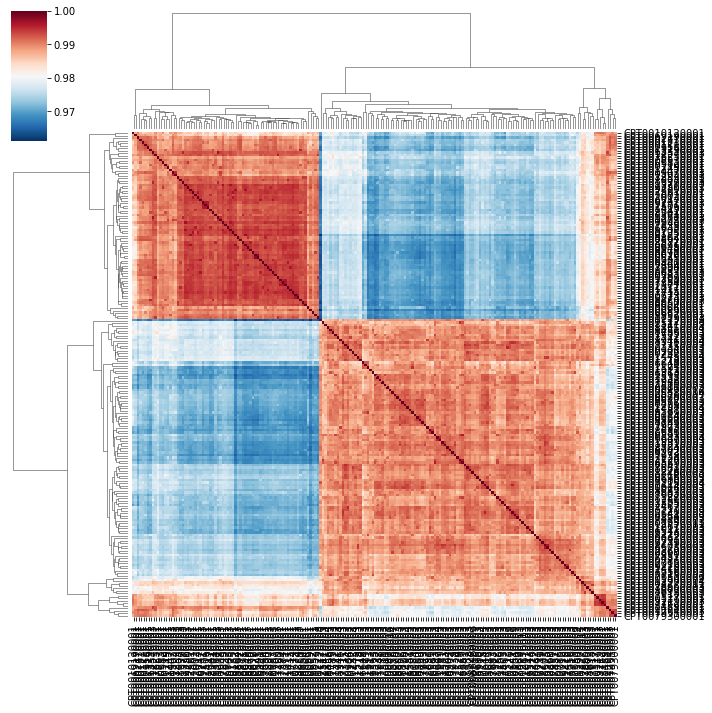

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out poor quality samples
# Check the correlation between samples

all_cases = [c for c in prot_df.columns if 'CP' in c]
corr = prot_df[all_cases].corr()
sns.clustermap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='RdBu_r', row_cluster=True, col_cluster=True)
if save_fig:
    plt.savefig(f'{fig_dir}Heatmap_protein_imputed.svg')


In [18]:
# Print out the minimum correlation:
min(np.min(corr))
# Since this is so high we can conclude all the protein samples are pretty strongly correlated and
# we don't need to filter out any samples.

0.9612818725719975

## Add in sample info to the protein dataset

While we have the aliqout IDs, we want to add in other info, such as patient demographics we may use
for performing DE analysis experiments


In [19]:
# In the protein dataframe they use the Aliquot ID rather than the case ID
# We want to match this to the case and if it was tumour or normal sample

# Get the protein aliqot IDs and we want to match these with patient info
p_Aliquot_ID = [c for c in prot_df.columns if 'CPT' in c]

# Get the patient info
sample_type = clin_prot_df['Group'].values
cond_ids = []
cond_names = []
case_ids = []
cases = clin_prot_df['ParticipantID'].values

# Iterate though the different aliqots
for cp in p_Aliquot_ID:
    # Iterate through the clinical samples to find a match
    for i, c in enumerate(clin_prot_df['Aliquot ID'].values):
        if c == cp:
            cond_names.append(sample_type[i])
            case_ids.append(cases[i])
            if sample_type[i] == 'Tumor':
                cond_ids.append(1)
            else:
                cond_ids.append(0)
            break

# Make a sample Dataframe
prot_sample_data = pd.DataFrame()
prot_sample_data['AliquotID'] = p_Aliquot_ID
prot_sample_data['CondName'] = cond_names
prot_sample_data['CondId'] = cond_ids
prot_sample_data['CaseId'] = case_ids
prot_sample_data['SafeCases'] = [c.replace('-', '.') for c in case_ids]
prot_sample_data['FullLabel'] = [f'{cond_names[i]}_{case_ids[i].replace("-", ".")}_{a}' for i, a in enumerate(p_Aliquot_ID)]


In [20]:
# Rename the columns to have the aliqiot ID in it
column_map = {}
for i, a in enumerate(p_Aliquot_ID):
    column_map[a] = f'{cond_names[i]}_{case_ids[i].replace("-", ".")}_{a}'
prot_df = prot_df.rename(columns=column_map)
prot_df.to_csv(f'{output_dir}protein_df.csv', index=False)

In [21]:
meta_cols = [c for c in prot_df.columns if 'CP' not in c]
meta_cols

['external_gene_name',
 'ensembl_gene_id',
 'chromosome_name',
 'start_position',
 'end_position',
 'strand',
 'entrezgene_id',
 'external_synonym',
 'hgnc_symbol',
 'original_gene_id']

## Add in clinical info to the protein sample dataframe

- Race demographics (ethnicity_self_identified)
- Age (age) --> separate into young (< 50) mid (50 - 70), old (> 70)?
- BMI (BMI) --> separate into underweight (< 19) normal (19 - 25), pre-obese (26-30), obsesity class 1 (30 - 35), obesisty class 2 (35 - 40), obesity class 3) (41 - 49

In [25]:
# Read in the clinical file we made with all the molecular info from our data
clin_df = pd.read_csv(f'{output_dir}clinical_sircle.csv')
# Now we want to merge the clinical info with the cases from the sample df
prot_sample_df = prot_sample_data.set_index("CaseId").join(clin_df.set_index("case_id"), how="left", rsuffix='')

## -------- Rename the columns
new_full_label_map = {}
new_full_label = []
for full_label in prot_sample_df['FullLabel'].values:
    new_label = f'Protein_{full_label}'
    new_full_label.append(new_label)
    new_full_label_map[full_label] = new_label
# Update
prot_sample_df['FullLabel'] = new_full_label
prot_df = prot_df.rename(columns=new_full_label_map)

prot_df.to_csv(f'{output_dir}prot_data_sircle.csv', index=False)

prot_sample_df.to_csv(f'{output_dir}prot_sample_data_sircle.csv')
prot_sample_df

,AliquotID,CondName,CondId,SafeCases,FullLabel,gender,TumorStage,AgeGrouped,BMIGrouped,RaceGrouped,...,CIMPStatus,GenomeInstability,VHL+TTN,VHL-TTN,VHL+PBRM1,VHL-PBRM1,PBRM1-VHL,VHL,TTN-VHL,TTN+PBRM1-VHL
C3L-00004,CPT0001550001,Normal,0,C3L.00004,Protein_Normal_C3L.00004_CPT0001550001,Male,Stage III,old,normal,White,...,1,0,0,1,1,0,0,0,0,0
C3L-00004,CPT0001540009,Tumor,1,C3L.00004,Protein_Tumor_C3L.00004_CPT0001540009,Male,Stage III,old,normal,White,...,1,0,0,1,1,0,0,0,0,0
C3L-00010,CPT0001230001,Normal,0,C3L.00010,Protein_Normal_C3L.00010_CPT0001230001,Male,Stage I,young,between,White,...,0,0,0,1,0,1,0,1,0,0
C3L-00010,CPT0001220008,Tumor,1,C3L.00010,Protein_Tumor_C3L.00010_CPT0001220008,Male,Stage I,young,between,White,...,0,0,0,1,0,1,0,1,0,0
C3L-00011,CPT0001340003,Tumor,1,C3L.00011,Protein_Tumor_C3L.00011_CPT0001340003,Female,Stage IV,old,between,White,...,1,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N-01649,CPT0088640003,Normal,0,C3N.01649,Protein_Normal_C3N.01649_CPT0088640003,Male,Stage III,middle,obese,White,...,0,0,1,0,1,0,0,0,0,0
C3N-01651,CPT0088710001,Normal,0,C3N.01651,Protein_Normal_C3N.01651_CPT0088710001,Male,Stage II,old,between,White,...,1,1,1,0,1,0,0,0,0,0
C3N-01651,CPT0088690003,Tumor,1,C3N.01651,Protein_Tumor_C3N.01651_CPT0088690003,Male,Stage II,old,between,White,...,1,1,1,0,1,0,0,0,0,0
C3N-01808,CPT0089480003,Normal,0,C3N.01808,Protein_Normal_C3N.01808_CPT0089480003,Male,Stage I,middle,between,White,...,0,0,0,0,0,0,0,0,0,0


In [26]:
pd.read_csv(f'{output_dir}prot_sample_data_sircle.csv')

,Unnamed: 0,AliquotID,CondName,CondId,SafeCases,FullLabel,gender,TumorStage,AgeGrouped,BMIGrouped,...,CIMPStatus,GenomeInstability,VHL+TTN,VHL-TTN,VHL+PBRM1,VHL-PBRM1,PBRM1-VHL,VHL,TTN-VHL,TTN+PBRM1-VHL
0,C3L-00004,CPT0001550001,Normal,0,C3L.00004,Protein_Normal_C3L.00004_CPT0001550001,Male,Stage III,old,normal,...,1,0,0,1,1,0,0,0,0,0
1,C3L-00004,CPT0001540009,Tumor,1,C3L.00004,Protein_Tumor_C3L.00004_CPT0001540009,Male,Stage III,old,normal,...,1,0,0,1,1,0,0,0,0,0
2,C3L-00010,CPT0001230001,Normal,0,C3L.00010,Protein_Normal_C3L.00010_CPT0001230001,Male,Stage I,young,between,...,0,0,0,1,0,1,0,1,0,0
3,C3L-00010,CPT0001220008,Tumor,1,C3L.00010,Protein_Tumor_C3L.00010_CPT0001220008,Male,Stage I,young,between,...,0,0,0,1,0,1,0,1,0,0
4,C3L-00011,CPT0001340003,Tumor,1,C3L.00011,Protein_Tumor_C3L.00011_CPT0001340003,Female,Stage IV,old,between,...,1,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,C3N-01649,CPT0088640003,Normal,0,C3N.01649,Protein_Normal_C3N.01649_CPT0088640003,Male,Stage III,middle,obese,...,0,0,1,0,1,0,0,0,0,0
190,C3N-01651,CPT0088710001,Normal,0,C3N.01651,Protein_Normal_C3N.01651_CPT0088710001,Male,Stage II,old,between,...,1,1,1,0,1,0,0,0,0,0
191,C3N-01651,CPT0088690003,Tumor,1,C3N.01651,Protein_Tumor_C3N.01651_CPT0088690003,Male,Stage II,old,between,...,1,1,1,0,1,0,0,0,0,0
192,C3N-01808,CPT0089480003,Normal,0,C3N.01808,Protein_Normal_C3N.01808_CPT0089480003,Male,Stage I,middle,between,...,0,0,0,0,0,0,0,0,0,0


In [28]:
prot_df = pd.read_csv(f'{output_dir}prot_data_sircle.csv')
prot_sample_df = pd.read_csv(f'{output_dir}prot_sample_data_sircle.csv', index_col=0)
prot_sample_df = prot_sample_df[~prot_sample_df.index.isin(non_ccrcc)] # Ensure we only include ccRCC patients
prot_sample_df

,AliquotID,CondName,CondId,SafeCases,FullLabel,gender,TumorStage,AgeGrouped,BMIGrouped,RaceGrouped,...,CIMPStatus,GenomeInstability,VHL+TTN,VHL-TTN,VHL+PBRM1,VHL-PBRM1,PBRM1-VHL,VHL,TTN-VHL,TTN+PBRM1-VHL
C3L-00004,CPT0001550001,Normal,0,C3L.00004,Protein_Normal_C3L.00004_CPT0001550001,Male,Stage III,old,normal,White,...,1,0,0,1,1,0,0,0,0,0
C3L-00004,CPT0001540009,Tumor,1,C3L.00004,Protein_Tumor_C3L.00004_CPT0001540009,Male,Stage III,old,normal,White,...,1,0,0,1,1,0,0,0,0,0
C3L-00010,CPT0001230001,Normal,0,C3L.00010,Protein_Normal_C3L.00010_CPT0001230001,Male,Stage I,young,between,White,...,0,0,0,1,0,1,0,1,0,0
C3L-00010,CPT0001220008,Tumor,1,C3L.00010,Protein_Tumor_C3L.00010_CPT0001220008,Male,Stage I,young,between,White,...,0,0,0,1,0,1,0,1,0,0
C3L-00011,CPT0001340003,Tumor,1,C3L.00011,Protein_Tumor_C3L.00011_CPT0001340003,Female,Stage IV,old,between,White,...,1,1,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N-01649,CPT0088640003,Normal,0,C3N.01649,Protein_Normal_C3N.01649_CPT0088640003,Male,Stage III,middle,obese,White,...,0,0,1,0,1,0,0,0,0,0
C3N-01651,CPT0088710001,Normal,0,C3N.01651,Protein_Normal_C3N.01651_CPT0088710001,Male,Stage II,old,between,White,...,1,1,1,0,1,0,0,0,0,0
C3N-01651,CPT0088690003,Tumor,1,C3N.01651,Protein_Tumor_C3N.01651_CPT0088690003,Male,Stage II,old,between,White,...,1,1,1,0,1,0,0,0,0,0
C3N-01808,CPT0089480003,Normal,0,C3N.01808,Protein_Normal_C3N.01808_CPT0089480003,Male,Stage I,middle,between,White,...,0,0,0,0,0,0,0,0,0,0


In [29]:
meta_cols = [c for c in prot_df.columns if 'CP' not in c]
prot_df = prot_df[meta_cols + list(prot_sample_df['FullLabel'].values)]

prot_df.to_csv(f'{output_dir}prot_data_sircle_ccRCC.csv', index=False)

prot_sample_df.to_csv(f'{output_dir}prot_sample_data_sircle_ccRCC.csv')